In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings 
warnings.filterwarnings('ignore')

In [2]:
def parser(x):
    return pd.datetime.strptime(x,'%Y-%m')

In [3]:
dataset = pd.read_csv('sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

<ipython-input-2-b9eae3509eb8>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x,'%Y-%m')


In [4]:
dataset.head()

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Sales, dtype: int64

1. Plot Dataset

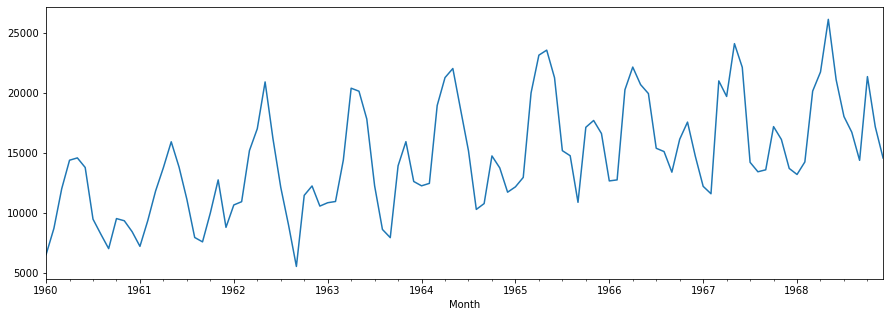

In [6]:
dataset.plot(figsize=(15,5))
plt.show()

2. Dari hasil plot data tersebut terdapat trend naik serta seasonality.

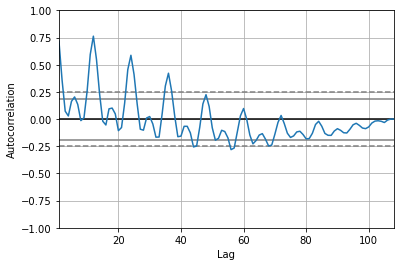

In [17]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

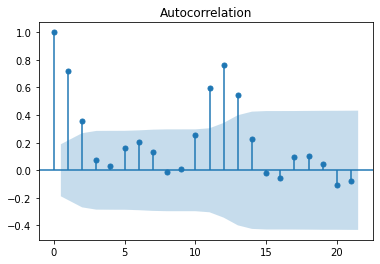

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dataset)
plt.show()

In [18]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

ARIMA

In [21]:
model = ARIMA(dataset, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  107
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1016.733
Method:                       css-mle   S.D. of innovations           3238.735
Date:                Thu, 17 Sep 2020   AIC                           2041.466
Time:                        20:09:20   BIC                           2052.157
Sample:                    02-01-1960   HQIC                          2045.800
                         - 12-01-1968                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            76.9928    324.839      0.237      0.813    -559.679     713.665
ar.L1.D.Sales     0.1764      0.096      1.845      0.065      -0.011       0.364
ar.L2.D.Sales    -0.1413      0.096     

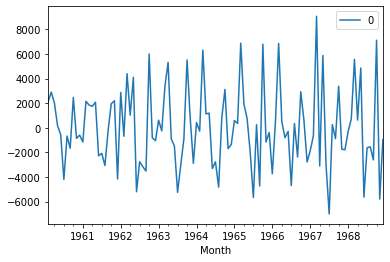

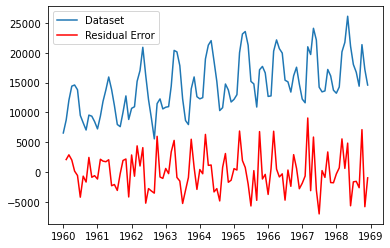

In [22]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [23]:
residuals

,0
Month,
1960-02-01,2101.007244
1960-03-01,2896.256212
1960-04-01,2020.611238
1960-05-01,165.711816
1960-06-01,-569.492829
...,...
1968-08-01,-1544.948502
1968-09-01,-2613.889005
1968-10-01,7111.039617


In [24]:
print(residuals.describe())

                 0
count   107.000000
mean      3.240586
std    3254.494281
min   -7001.272796
25%   -2038.577337
50%    -303.731681
75%    1939.892396
max    9059.090161


# Rolling Forecast ARIMA Model (Prediction)

predicted=22783.356800, expected=22135.000000
predicted=21269.538031, expected=20677.000000
predicted=19960.646574, expected=19933.000000
predicted=20179.490531, expected=15388.000000
predicted=14206.276263, expected=15113.000000
predicted=16096.206791, expected=13401.000000
predicted=12999.689219, expected=16135.000000
predicted=17397.064416, expected=17562.000000
predicted=17565.458614, expected=14720.000000
predicted=13659.668781, expected=12225.000000
predicted=12120.397480, expected=11608.000000
predicted=11989.655305, expected=20985.000000
predicted=24142.927093, expected=19692.000000
predicted=17421.679989, expected=24081.000000
predicted=25461.754717, expected=22114.000000
predicted=21245.641262, expected=14220.000000
predicted=12777.448753, expected=13434.000000
predicted=14705.292585, expected=13598.000000
predicted=13834.077449, expected=17187.000000
predicted=18091.080718, expected=16119.000000
predicted=15368.239171, expected=13713.000000
predicted=13421.723005, expected=1

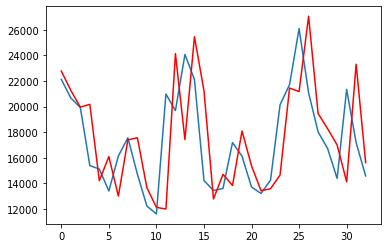

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

values = dataset.values
size = int(len(values) * 0.7)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    prediction = output[0]
    predictions.append(prediction)
    expected = test[t]
    history.append(expected)
    print('predicted=%f, expected=%f' % (prediction, expected))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.2f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [31]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = sqrt(mean_squared_error(test, predictions))
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [32]:
p_values = range(0, 10)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4884.693
ARIMA(0, 0, 1) RMSE=3724.160
ARIMA(0, 0, 2) RMSE=3415.471
ARIMA(0, 1, 0) RMSE=3679.761
ARIMA(0, 1, 1) RMSE=3761.427
ARIMA(0, 1, 2) RMSE=3910.601
ARIMA(0, 2, 0) RMSE=5163.372
ARIMA(0, 2, 1) RMSE=3737.633
ARIMA(1, 0, 0) RMSE=3423.925
ARIMA(1, 0, 1) RMSE=3433.940
ARIMA(1, 0, 2) RMSE=3375.195
ARIMA(1, 1, 0) RMSE=3763.883
ARIMA(1, 2, 0) RMSE=4769.673
ARIMA(2, 0, 0) RMSE=3464.026
ARIMA(2, 1, 0) RMSE=3782.046
ARIMA(2, 2, 0) RMSE=4766.378
ARIMA(3, 0, 0) RMSE=3482.694
ARIMA(3, 1, 0) RMSE=3563.109
ARIMA(3, 2, 0) RMSE=4695.343
ARIMA(4, 0, 0) RMSE=3410.780
ARIMA(4, 1, 0) RMSE=3374.413
ARIMA(4, 2, 0) RMSE=3679.747
ARIMA(5, 0, 0) RMSE=3309.748
ARIMA(5, 1, 0) RMSE=3282.985
ARIMA(5, 2, 0) RMSE=3712.808
ARIMA(6, 0, 0) RMSE=3161.615
ARIMA(6, 1, 0) RMSE=3289.272
ARIMA(6, 2, 0) RMSE=3684.894
ARIMA(7, 0, 0) RMSE=3226.686
ARIMA(7, 1, 0) RMSE=3443.220
ARIMA(7, 2, 0) RMSE=3640.891
ARIMA(8, 0, 0) RMSE=3294.629
ARIMA(8, 1, 0) RMSE=3151.020
ARIMA(8, 2, 0) RMSE=3768.630
ARIMA(9, 0, 0)

In [ ]:
3. Dari hyperparameter tuning diatas, diperoleh hasil ARIMA terbaik dengan nilai p, d, q = (9, 1, 0) dan RMSE sebesar 2728.462

SARIMAX

In [33]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [34]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 4. Hasil terbaik untuk SARIMAX tidak dapat diketahui karna waktu processing yang sangat lama karena algoritma yang rumit.